# Used Vehicle Price Prediction Model

Main Imports

In [92]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import copy

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
from mpl_toolkits import mplot3d
import pandas_profiling as pp
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ml models
from sklearn.linear_model import LinearRegression,LogisticRegression, SGDRegressor, RidgeCV

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp

from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from scipy.stats import pearsonr
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# tuning the model 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

pd.pandas.set_option('display.max_rows', None)
pd.pandas.set_option('display.max_columns', None)


In [93]:
#dataset import
df = pd.read_csv('vehicles_price_data.csv')

In [94]:
#data set analysis
#pp.ProfileReport(df)

# Preparing Data

In [95]:
print(df.info())
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101831 entries, 0 to 101830
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            101831 non-null  int64  
 1   price         101831 non-null  int64  
 2   year          101831 non-null  float64
 3   manufacturer  101831 non-null  object 
 4   model         101831 non-null  object 
 5   condition     101831 non-null  object 
 6   cylinders     101831 non-null  object 
 7   fuel          101831 non-null  object 
 8   odometer      101831 non-null  float64
 9   transmission  101831 non-null  object 
 10  type          101831 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 8.5+ MB
None


In [96]:
df['year'] = df['year'].astype(int)
df['year'].dtype

dtype('int32')

In [97]:
df = df[df['price'].between(1000, 265000)]

In [98]:
df.drop(['id', 'model'], axis = 1, inplace = True) 

In [99]:
df.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type
0,16995,2007,gmc,good,8 cylinders,diesel,254217.0,automatic,truck
1,13995,2012,ford,good,6 cylinders,gas,188406.0,automatic,truck
2,7995,2010,chevrolet,good,4 cylinders,gas,108124.0,automatic,SUV
3,8995,2011,chevrolet,good,6 cylinders,gas,178054.0,automatic,SUV
4,10995,2014,ford,good,6 cylinders,gas,170259.0,automatic,SUV


In [100]:
df.reset_index(drop=True, inplace=True)

In [101]:
df.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type
0,16995,2007,gmc,good,8 cylinders,diesel,254217.0,automatic,truck
1,13995,2012,ford,good,6 cylinders,gas,188406.0,automatic,truck
2,7995,2010,chevrolet,good,4 cylinders,gas,108124.0,automatic,SUV
3,8995,2011,chevrolet,good,6 cylinders,gas,178054.0,automatic,SUV
4,10995,2014,ford,good,6 cylinders,gas,170259.0,automatic,SUV


In [102]:
options = ['ford', 'jeep','chevrolet','nissan','toyota','honda','audi','dodge','gmc','ram']
df = df.loc[df['manufacturer'].isin(options)]

In [103]:
df.type.unique()

array(['truck', 'SUV', 'mini-van', 'sedan', 'coupe', 'pickup', 'wagon',
       'van', 'other', 'convertible', 'hatchback', 'bus', 'offroad'],
      dtype=object)

In [104]:
options = ['truck', 'SUV','sedan','pickup','wagon','coupe','hatchback','van','mini-van']
df = df.loc[df['type'].isin(options)]

In [105]:
df.shape

(63991, 9)

# Lablel Encoding

In [106]:
#manufacturer
df.manufacturer.unique()

array(['gmc', 'ford', 'chevrolet', 'ram', 'nissan', 'dodge', 'toyota',
       'audi', 'jeep', 'honda'], dtype=object)

In [107]:
manu_encode = {"manufacturer":     {"chevrolet": 1, "ford": 2,"nissan":3 , "jeep": 4,"toyota" :5,"honda" : 6,"audi" : 7,"gmc" :8,"ram" :9, "dodge" : 10,},}


df = df.replace(manu_encode)

In [108]:
# condition
condition_encode = {"condition": {"new":1,"like new":2,"excellent":3,"good":4,"fair":5,"salvage":6, }}

df = df.replace(condition_encode)

In [109]:
#cylinders
cylinders_encode = {"cylinders": {"3 cylinders":1,"4 cylinders":2,"5 cylinders":3,"6 cylinders":4,"8 cylinders":5,"10 cylinders":6,"12 cylinders": 7,"other":8 }}

df = df.replace(cylinders_encode)

In [110]:
#fuel
fuel_encode = {"fuel": {"gas":1,"diesel":2,"hybrid":3,"electric":4,"other":5}}

df = df.replace(fuel_encode)

In [111]:
#transmission
transmission_encode = {"transmission": {"automatic":1,"manual":2,"other":3,}}

df = df.replace(transmission_encode)

In [112]:
#type
type_encode = {"type": {"truck":1,"SUV":2,"sedan":3,"pickup":4,"wagon":5,"coupe":6,"hatchback":7,"van":8,"mini-van":9,}}

df = df.replace(type_encode)

In [113]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63991 entries, 0 to 95766
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         63991 non-null  int64  
 1   year          63991 non-null  int32  
 2   manufacturer  63991 non-null  int64  
 3   condition     63991 non-null  int64  
 4   cylinders     63991 non-null  int64  
 5   fuel          63991 non-null  int64  
 6   odometer      63991 non-null  float64
 7   transmission  63991 non-null  int64  
 8   type          63991 non-null  int64  
dtypes: float64(1), int32(1), int64(7)
memory usage: 4.6 MB
None


In [114]:
df.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type
0,16995,2007,8,4,5,2,254217.0,1,1
1,13995,2012,2,4,4,1,188406.0,1,1
2,7995,2010,1,4,2,1,108124.0,1,2
3,8995,2011,1,4,4,1,178054.0,1,2
4,10995,2014,2,4,4,1,170259.0,1,2


# ML Models

In [115]:
#dropping target value
target_name = 'price'
train_target0 = df[target_name]
df = df.drop([target_name], axis=1)

In [116]:
# train test split
df, test0, train_target0, test_target0 = train_test_split(df, train_target0, test_size=0.2, random_state=0)

In [117]:
# Data splitting For boosting model
train0b = df
train_target0b = train_target0

trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=0.3, random_state=0)

In [118]:
# For boosting model
train0b = df
train_target0b = train_target0
# Synthesis valid as test for selection models
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=0.3, random_state=0)

In [119]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [120]:
df.head(3)

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type
0,-0.433291,-0.687114,0.900254,1.051079,-0.268173,0.240225,-0.321815,0.329469
1,-1.651094,-1.048640,-0.469757,0.250013,-0.268173,-0.874214,1.822443,0.329469
2,0.784511,-0.687114,0.900254,-1.352121,-0.268173,-0.471296,-0.321815,-0.140263


In [121]:
#  test for selection models
train, test, target, target_test = train_test_split(df, train_target0, test_size=0.3, random_state=0)

In [122]:
#For models from Sklearn
testn = pd.DataFrame(scaler.transform(test0), columns = test0.columns)

In [123]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [124]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [125]:

def acc_boosting_model(num,model,train,test,num_iteration=0):
    # Calculation of accuracy of boosting model by different metrics
    
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(targetb, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_testb, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [126]:
def acc_model(num,model,train,test):
    # Calculation of accuracy of model from Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [127]:
random_forest = RandomForestRegressor()
random_forest.fit(train, target)
acc_model(1,random_forest,train,test)

target =  [11990  9000 33590 39590  4000]
ytrain =  [11599.69       10458.65       33037.2        39573.03809524
  4793.99866667]
acc(r2_score) for train = 97.29
acc(relative error) for train = 6.11
acc(rmse) for train = 188709.65
target_test = [ 9995 37988  2495 14900 39000]
ytest = [ 9238.24       18067.72        3519.01666667  9996.49
 34042.19666667]
acc(r2_score) for test = 85.59
acc(relative error) for test = 16.0
acc(rmse) for test = 429896.48


In [128]:
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

In [129]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=8000,verbose_eval=500, valid_sets=valid_set)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5115
[LightGBM] [Info] Number of data points in the train set: 28667, number of used features: 8
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 14040.423204
Training until validation scores don't improve for 8000 rounds
[500]	valid_0's rmse: 5154.59
[1000]	valid_0's rmse: 5005.55
[1500]	valid_0's rmse: 4956.93
[2000]	valid_0's rmse: 4926.56
[2500]	valid_0's rmse: 4910.75
[3000]	valid_0's rmse: 4893.36
[3500]	valid_0's rmse: 4880.64
[4000]	valid_0's rmse: 4867.21
[45

In [130]:
acc_boosting_model(3,modelL,trainb,testb,modelL.best_iteration)

target =  [11990  9000 33590 39590  4000]
ytrain =  [11883.57721347 13032.45062977 30758.48363977 38890.15027565
  5555.18265201]
acc(r2_score) for train = 90.11
acc(relative error) for train = 14.95
acc(rmse) for train = 360762.76
target_test = [ 9995 37988  2495 14900 39000]
ytest = [10405.5754032  16505.56230829  3173.81240364 12485.43546856
 36346.60756965]
acc(r2_score) for test = 84.79
acc(relative error) for test = 18.24
acc(rmse) for test = 441708.94


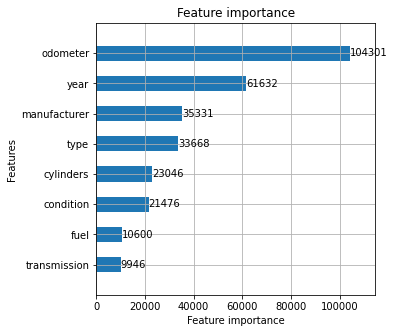

In [131]:
fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

In [132]:
#For models from Sklearn
testn = pd.DataFrame(scaler.transform(test0), columns = test0.columns)

In [133]:
# LGB Regression model train
lgb_predict = modelL.predict(test0)
lgb_predict[:3]

array([11882.32775075,  7543.7076183 ,  4974.83393944])

In [134]:
final_df = test_target0.values
final_df = pd.DataFrame(final_df,columns=['Real_price'])
final_df['predicted_prices'] = lgb_predict.astype(int)
final_df['difference'] = abs(final_df['Real_price'] - final_df['predicted_prices']).astype(int)
final_df.head(50)

,Real_price,predicted_prices,difference
0,7995,11882,3887
1,7450,7543,93
2,4500,4974,474
3,6500,5755,745
4,3500,3218,282
5,39785,41682,1897
6,9990,9164,826
7,3995,4464,469
8,6500,5760,740
9,17590,16765,825


In [135]:
lgb_predict[10]

7578.340028791844

In [136]:
import joblib
filename = 'vehicle_price_prediction_model.sav'
joblib.dump(modelL,filename)

6115.071528179269

In [ ]:
import joblib
filename = 'vehicle_price_prediction_model.sav'
joblib.dump(modelL,filename)